# SMIB with AVR

In [1]:
import numpy as np 
import sympy as sym
from sympy.utilities.lambdify import lambdify, implemented_function


sin = sym.sin
cos = sym.cos

In [2]:
delta, omega, e1d, e1q = sym.symbols('delta omega e1d e1q')
i_d, i_q, v_d, v_q = sym.symbols('i_d i_q v_d v_q')
v_f, p_m = sym.symbols('v_f p_m')
X_d, X_q, X1d, X1q, X_l, R_a, T1d0, T1q0  = sym.symbols('X_d X_q X1d X1q X_l R_a T1d0 T1q0')
H, D = sym.symbols('H D')
V_t, theta_t, P_t, Q_t, V_inf, theta_inf = sym.symbols('V_t, theta_t, P_t, Q_t, V_inf, theta_inf')
B_t_inf, B_t0, G_t_inf, G_t0 = sym.symbols('B_t_inf, B_t0, G_t_inf, G_t0')
Omega_b, p_e = sym.symbols('Omega_b p_e')
v_c, K_a, T_r,V_ref, v_f_avr = sym.symbols('v_c, K_a, T_r,V_ref, v_f_avr')

## Initialization problem (backward)

In [3]:
N_x = 5
N_y = 10

ddelta = Omega_b * (omega - 1);
domega = 1/(2*H) * ( p_m - p_e - D * ( omega - 1)) ;
de1q   = 1/T1d0 * ( -e1q - (X_d - X1d ) * i_d + v_f);
de1d   = 1/T1q0 * ( -e1d + (X_q - X1q ) * i_q ) 
dv_c   = 1/T_r * ( V_t - v_c )


g1 = v_q + R_a * i_q - e1q + (X1d - X_l)*i_d;
g2 = v_d + R_a * i_d - e1d - (X1q - X_l)*i_q;
g3 = p_e - (v_q + R_a*i_q)*i_q - (v_d + R_a*i_d)*i_d ;
g4 = v_d - V_t * sin(delta - theta_t);
g5 = v_q - V_t * cos(delta - theta_t);
g6 = v_d * i_d + v_q * i_q - P_t; 
g7 = v_q * i_d - v_d * i_q - Q_t;
g8 =  V_t**2*(G_t_inf+G_t0) - V_t*V_inf*(G_t_inf * cos(theta_t - theta_inf) + B_t_inf * sin(theta_t - theta_inf)) - P_t  
g9 = -V_t**2*(B_t_inf+B_t0) - V_t*V_inf*(G_t_inf * sin(theta_t - theta_inf) - B_t_inf * cos(theta_t - theta_inf)) - Q_t
g10 = K_a*(V_ref - v_c) - v_f


In [4]:
x = sym.Matrix([delta,omega,e1q,e1d,v_c])
f = sym.Matrix([ddelta, domega, de1q, de1d, dv_c])

y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,p_m,V_ref,theta_t,Q_t, v_f])
g = sym.Matrix([ g1, g2, g3, g4, g5, g6,   g7,     g8, g9, g10])

In [5]:
F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [6]:
X_d = 1.81
X1d  = 0.3
T1d0  = 8.0
X_q  = 1.76
X1q  = 0.65
T1q0  = 1.0 
R_a  =  0.003 
X_l  = 0.15  
H  = 3.5   
Omega_b = 2*np.pi*60
Z_t_inf = 0.15+1.0/(1.0/0.5+1.0/0.93)

params = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'D' : 0.1,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.0, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
    'K_a':10.0,   
    'T_r':0.05,  
}



In [7]:
u = sym.Matrix([P_t,V_t])

f_eval = lambdify((x,y,u), f.subs(params), "numpy")
g_eval = lambdify((x,y,u), g.subs(params), "numpy")
F_x_eval = lambdify((x,y,u), F_x.subs(params), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params), "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)


lam = lambdify((xi_sym,u), lam_sym.subs(params), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params), "numpy")



In [8]:
def nr(xi_0,u,lam,Lam):
    max_iter = 1000
    tol = 1.0e-8
    for it in range(max_iter):

        Dxi = np.linalg.solve(-Lam(xi_0,u),lam(xi_0,u))
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
    return xi_0
#%timeit nr(x_0,lam,Lam)

In [9]:
xi_0 = np.ones((N_x+N_y,1))
u_val = np.array([[0.9],[1.0]])
xi_ini = nr(xi_0,u_val,lam,Lam)
xi_ini

x_val = xi_ini[0:N_x]
y_val = xi_ini[N_x:(N_x+N_y)]

In [10]:
np.linalg.det(G_y_eval(x_val,y_val,u_val))

0.0

## Simulation problem (forward)

In [26]:
N_x = 5
N_y = 10

x = sym.Matrix([delta,omega,e1q,e1d,v_c])
y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,P_t,Q_t,theta_t,V_t,v_f])
u = sym.Matrix([p_m,V_ref,D,K_a])

f = sym.Matrix([ddelta, domega, de1q, de1d, dv_c])
g = sym.Matrix([g1, g2, g3, g4, g5,g6, g7, g8,g9,g10])
h = sym.Matrix([P_t,Q_t,V_t])

F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [27]:
params_run = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.01, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
'T_r':0.05,  
}

f_eval = lambdify((x,y,u), f.subs(params_run), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_run), "numpy")

F_x_eval = lambdify((x,y,u), F_x.subs(params_run), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_run), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_run), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_run), "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)
 

lam = lambdify((xi_sym,u), lam_sym.subs(params_run), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_run), "numpy")
h_eval = lambdify((xi_sym,u), h.subs(params_run), "numpy")

In [29]:
def nr(xi_0,u_val,lam,Lam):
    max_iter = 100
    tol = 1.0e-8
    for it in range(max_iter):

        Dxi = np.linalg.solve(-Lam(xi_0,u_val),lam(xi_0,u_val))
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
        if it==max_iter-1: 
            print('No convergence after', it)
            break
    return xi_0,h_eval(xi_0,u_val)

xi_0 = np.ones((N_x+N_y,1))
xi_0[0] = 0.1
# u = sym.Matrix([p_m,V_ref,D,K_a])
u_val = np.array([0.9,1.0,0.1,50])
xi_0,z = nr(xi_0,u_val,lam,Lam)
print(xi_0)
print(z)

[[ 1.2960648 ]
 [ 1.        ]
 [ 0.81879947]
 [ 0.46469837]
 [ 0.95609274]
 [ 0.91163158]
 [ 0.41864718]
 [ 0.9       ]
 [ 0.67128707]
 [ 0.68079879]
 [ 0.89698099]
 [ 0.33960524]
 [ 0.51770137]
 [ 0.95609274]
 [ 2.19536316]]
[[ 0.89698099]
 [ 0.33960524]
 [ 0.95609274]]


In [30]:
def autos(u_val,xi_0):
    
    xi_run, z = nr(xi_0,u_val,lam,Lam)

    lam(xi_run, u_val)

    x_val = xi_run[0:N_x]
    y_val = xi_run[N_x:(N_x+N_y)]

    F_x_val = F_x_eval(x_val,y_val,u_val) 
    F_y_val = F_y_eval(x_val,y_val,u_val) 
    G_x_val = G_x_eval(x_val,y_val,u_val) 
    G_y_val = G_y_eval(x_val,y_val,u_val) 
    
    A =  F_x_val - F_y_val @ np.linalg.inv(G_y_val) @ G_x_val
    lamb, Phi = np.linalg.eig(A)
    return lamb, z

autos(u_val,xi_0)

(array([-15.35024952+0.j        ,   0.02818222+7.81121087j,
          0.02818222-7.81121087j,  -5.50391837+0.j        ,  -1.77790056+0.j        ]),
 array([[ 0.89698099],
        [ 0.33960524],
        [ 0.95609274]]))

In [31]:
x_val = xi_0[0:N_x]
y_val = xi_0[N_x:(N_x+N_y)]
G_y_eval(x_val,y_val,u_val)

array([[ 0.15      ,  0.003     ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.003     , -0.5       ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.67675686, -0.68331067,  1.        , -0.91163158, -0.41864718,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.68079879, -0.70211502,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        , -0.67128707, -0.71206355,  0.        ],
       [ 0.67128707,  0.68079879,  0.        ,  0.91163158,  0.41864718,
        -1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.68079879, -0.67128707,  0.        , -0.41864718,  0.91163158,
         0.        , -1.        ,  0.        

In [42]:
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 


<IPython.core.display.Javascript object>


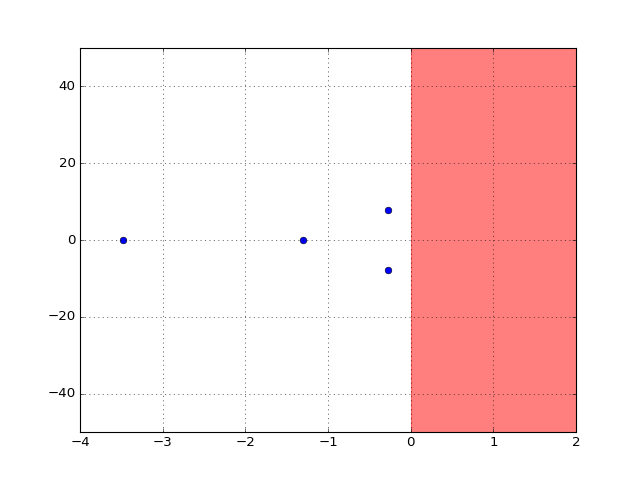

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_animated(True)
plt.xlim(-4, 2)
plt.ylim(-50, 50)
plt.grid(True)

poles = ax.plot([], 'o') 
#display(fig)

r1 = patches.Rectangle((0,-100), 500, 200, color="red", alpha=0.5)
ax.add_patch(r1)

def update(p_m,v_ref,D,K_a):
    
    u_val = np.array([p_m,v_ref,D,K_a])
    lamb, z = autos(u_val,xi_0)
    poles[0].set_xdata(lamb.real)
    poles[0].set_ydata(lamb.imag)
    
    print('P   = {:2.2f}'.format(z[0,0]))
    print('Q   = {:2.2f}'.format(z[1,0]))
    print('V_t = {:2.2f}'.format(z[2,0]))



sld_p_m = widgets.FloatSlider(min=0,max=1.2,step=0.01,value=u_val[0])
sld_v_ref = widgets.FloatSlider(min=u_val[1]-0.5,max=u_val[1]+0.5,step=0.01,value=u_val[1])
sld_D = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=params['D'])
sld_Ka = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=u_val[3])
interaction = interactive(update,
                          p_m=sld_p_m,
                          v_ref=sld_v_ref,
                          D=sld_D,
                          K_a=sld_Ka,
                          continuous_update=False)    

In [48]:
display(interaction)

P   = 0.58
Q   = 0.18
V_t = 0.95
